Disclaimer: This project was done purely out of mathematical curiosity and is almost certainly overly elegant and largely impractical. That said math is fun :)

Consider your typical gradient descent environment in which you are given a function:

\begin{equation*} 
F(X): R^N \to R 
\\
\nabla F(X): R^N \to R^N
\\
X \in R^N
\end{equation*}

In [25]:
import numpy as np
from numpy import dot
import theano as th
import theano.tensor as T

#Compiling theano tensor
x = T.dscalar('x')

y = T.dscalar('y')

#z = T.pow(x,2) + T.pow(y,2) - x - y + 1 #some alternates to play with

#z = T.pow(x,2) + T.pow(y,2)

z = T.pow(x,3) + T.pow(y,3) - x - y - T.pow(x-y,2) + np.log(abs(x)+.5) -T.exp(T.sin(y))

f = th.function([x,y],z)

<IPython.core.display.Javascript object>


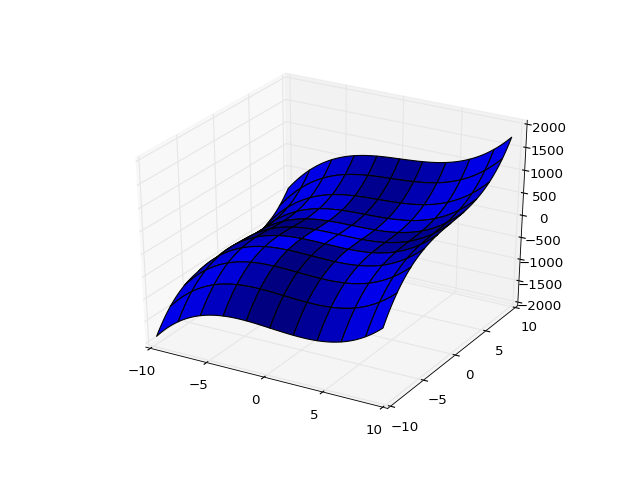

In [26]:
#Plotting said function within our bounds
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

bounds = [[-10,10],[-10,10]]

res = 100

X = np.zeros([res-2,res-2])

dx = (bounds[0][1] - bounds[0][0])/res

Y = np.zeros([res-2,res-2])

dy = (bounds[1][1] - bounds[1][0])/res

Z = np.zeros([res-2,res-2])

for k in range(0,res-2):
    for j in range(0,res-2):
        
        X[k,j] = dx*(j+1) + bounds[0][0]
        Y[k,j] = dy*(k+1) + bounds[1][0]
        
        Z[k,j] = f(X[k,j],Y[k,j])

fig = plt.figure()

ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z)

plt.show()

Let's assume that we are able to observe 


\begin{equation*}
\nabla F(X)
\\
\end{equation*}

Without error

In [27]:
###################################
#######Gradient Computation########
###################################

#generates a random point within given bounds
def sample(bounds):
    
    point = [0]*len(bounds)
    
    k = 0
    
    for bound in bounds:
        
        point[k] = (bound[1] - bound[0])*np.random.uniform() + bound[0]
        
        k += 1
        
    return np.array(point)

g = th.grad(z,[x,y])

grad = th.function([x,y],g)

point = sample(bounds)

print("Point: ",point)
print("Gradient: ",grad(*point))

Point:  [-9.66251611  3.51861174]
Gradient:  [array(305.3565073863831), array(10.423040396271148)]


_______
However, observing the true hessian:

\begin{equation*}
H(X): R^{N^2} \to R^{N^2}
\\
X \in R^N
\end{equation*}

Is either impossible or highly impractical. Then if we denote our current input as:

\begin{equation*}
X_t
\\
\end{equation*}

and our next location as 

\begin{equation*}
X_{t+ dt}
\\
dt \triangleq \|dX_t\|
\\
dX_t \triangleq X_{t + dt} - X_t
\end{equation*}

It follow obviously follows that:

\begin{equation*}
F(X_{t+ dt}) - F(X_t) = \nabla F(X)^t dX_t + \frac{dt}{2} V_t^t dX_t + O(dt^3)
\\
V_t \triangleq \frac{ \nabla F(X_{t + dt}) - \nabla F(X_t)}{dt} 
\end{equation*}

Where $$V_t \\$$
can be interpreted as an approximation of the directional derivative of our gradient in the direction 
$$dX_t \\$$

In [28]:
###################################
#####Cost Estimation and Error#####
######Using only the Gradient######
###################################

def length(vector):
    
    return sum(val**2 for val in vector)**.5

def normalize(vector):
    
    len_v = length(vector)
    
    return np.array([val/len_v for val in vector])

point = np.array(sample(bounds))

g1 = np.array(grad(*point))

lr = .5

grad_len = sum(partial**2 for partial in g1)**.5

norm_grad = np.array([partial/grad_len for partial in g1])

dx = np.array(norm_grad*lr)

point_2 = point + dx

f1 = f(*point)

f2 = f(*point_2)

act_gain = f2 - f1

est_gain = np.dot(g1,dx)

print("X: ",point)
print()
print("Gradient: ",g1)
print()
print("dX: ",dx)
print()
print("Estimated Gain: ",est_gain)
print()
print("Actual Gain: ",f2-f1)
print()
print("Error: ",abs(est_gain - act_gain))

X:  [-0.78324527 -8.5705073 ]

Gradient:  [ -15.51337887  235.24427862]

dX:  [-0.03290145  0.49891632]

Estimated Gain:  117.877622501

Actual Gain:  111.255660907

Error:  6.62196159406


In [29]:
###################################
#######Curviture Adjustment########
###################################


g2 = np.array(grad(*point_2))

V = (g2 - g1)/lr

curv_est_gain = np.dot(g1,dx) + .5*np.dot(V*lr,dx)

print("Initial Gradient: ",g1)
print()
print("New Gradient: ",g2)
print()
print("Directional Derivative of Gradient: ",V)
print()
print("Curvature Adjusted Estimate: ",curv_est_gain)
print()
print("Error: ",abs(curv_est_gain-act_gain))

Initial Gradient:  [ -15.51337887  235.24427862]

New Gradient:  [ -14.27239584  209.0439502 ]

Directional Derivative of Gradient:  [  2.48196606 -52.40065683]

Curvature Adjusted Estimate:  111.321321711

Error:  0.0656608033447


_______
Now it follows from vector calculus that if we are given directions 

$$
e_1, e_2 
\\ 
e_j \in R^N
\\
$$ 

and have gradient directional derivatives 
$$
V_{e_1}(X_t) , V_{e_2}(X_t) \\
$$

at a given point 

$$X_t \\ $$

For any new direction 
$$
e_3 \triangleq w_1 e_1 + w_2 e_2
\\
w_j \in R
\\
$$

we'll have

$$
V_3(X_t) = w_1 V_1 (X_t) + w_2 V_2 (X_t)
\\
$$

regardless of whether or not our initial vectors are perpandictular. Thus it follows that:
$$
F(X_t + e_3 ) - F(X_t) = \nabla F(X_t)^t e_3 + \frac{\| e_3 \|}{2} V_3^t e_3 + O(\| e_3 \|^3)
\\
$$
_______

In [30]:
###################################
#######Curviture Adjustment########
########Using Linear Combo#########
###################################

#step size
lr = .1

#normalized basis vectors
e1 = normalize(np.array([5.0,1.0]))

e2 = normalize(np.array([-1.0,3.0]))

#creating a new direction in our basis

w1 = 5.0

w2 = 3.0

e3 = normalize(w1*e1 + w2*e2)*lr

E = np.array([e1,e2])

#getting w1,w2 post rescaling
coord = np.linalg.solve(E.T,e3)

dx = e3

#Defining system of points

p1 = np.array(sample(bounds))

p2 = p1 + e1*lr

p3 = p1 + e2*lr

p4 = p1 + dx

#getting function values

f1 = f(*p1)

f2 = f(*p2)

f3 = f(*p3)

f4 = f(*p4)

#getting gradients

g1 = np.array(grad(*p1))

g2 = np.array(grad(*p2))

g3 = np.array(grad(*p3))

g4 = np.array(grad(*p4))

#Getting Directional Derivs

V1 = (g2-g1)/lr #Directional Derivative in e1 direction

V2 = (g3-g1)/lr #Directional Derivative in e2 direction

V3 = (V1*coord[0] + V2*coord[1])

#estimating gain

act_gain = f4 - f1

curv_est_gain = np.dot(g1,dx) + .5*np.dot(V3,dx)

grad_est_gain = np.dot(g1,dx)

print("Basis")
print(e1)
print()
print(e2)
print()
print("Step Direction: ",e3)
print()
print("X: ",p1)
print()
print("Gradient: ",g1)
print()
print("dx: ",dx)
print()
print("Gradient Estimated Gain: ",grad_est_gain)
print()
print("Curviture Adjusted Estimated Gain: ",curv_est_gain)
print()
print("Actual Gain: ",act_gain)
print()
print("Gradient Estimated Gain Error: ",abs(grad_est_gain - act_gain))
print()
print("Curviture Adjusted Estimated Gain Error: ",abs(curv_est_gain - act_gain))
print()
print("Estimated Directional Derivative: ",V3/lr)
print()
print("Actual Directional Derivative: ",(g4-g1)/lr)

Basis
[ 0.98058068  0.19611614]

[-0.31622777  0.9486833 ]

Step Direction:  [ 0.07186052  0.06954182]

X:  [ 4.72586362 -4.28492402]

Gradient:  [ 48.17114148  73.13323079]

dx:  [ 0.07186052  0.06954182]

Gradient Estimated Gain:  8.54742165327

Curviture Adjusted Estimated Gain:  8.56400728493

Actual Gain:  8.5633005034

Gradient Estimated Gain Error:  0.0158788501393

Curviture Adjusted Estimated Gain Error:  0.000706781525135

Estimated Directional Derivative:  [ 20.5826022  -16.49890486]

Actual Directional Derivative:  [ 20.45876966 -16.50301325]


___
And so given any linearly indepenpendent basis of directions
$$
e_1,e_1 ... e_N
\\
$$
and corresponding directional derivatives
$$
V_1,V_2, ... V_N
\\
$$

we can write our estimated change in the form:
$$
F(X_{t+ dt}) - F(X_t) = \nabla F(X_t)^t EW_t + \frac{1}{2} W^t V^t EW + O(\| EW \|^3)
\\
$$


where:
$$
E = \begin{bmatrix} e_1 & e_2 & ... & e_N \\
\end{bmatrix} \\$$ 
$$
V = \begin{bmatrix} V_1 & V_2 & ... & V_N \\
\end{bmatrix} \\$$

$$
W = \begin{bmatrix} w_1 \\  w_2 \\ \vdots \\  w_N \end{bmatrix} \\$$

with





$$
E W_t = \sum_{k=1}^N w_k e_k = X_{t+dt} - X_t 
\\
$$

Yielding the quadratic program approximation:

$$
W_t = - (V^t E)^{-1} \nabla F(X_t) 
\\
$$
_______

In [31]:
###################################
#######Solving for Optimal#########
########Direction using ###########
######Curvature Adjustment#########
###################################

#Unconstrained quadratic opt problem
#Using the previous calculation
E = np.array([e1,e2]).T

V = np.array([V1,V2]).T

B = -np.dot(E.T,g1) 

A = np.dot(V.T,E) 

dx_opt = np.linalg.solve(A,B)

dx = dot(E,dx_opt)

p_opt = p1 + dx

est_gain = np.dot(g1,dx)

f1 = f(*p1)

f_opt = f(*p_opt)

act_gain = -f1+f_opt

curve_est_gain = dot(g1,dx) + .5*dot(dx_opt,dot(V.T,dx))

print("Optimal Direction: ",dx_opt)

print()

print("Current Value: ",f1)

print()

print("Gradient Estimated Gain: ",est_gain)

print()

print("Curvature Adjusted Estimated Gain: ",curve_est_gain)
print()
print("Actual Gain: ",act_gain)
print()
print('Curvature Adjusted Error: ',abs(act_gain - curve_est_gain))
print()
print("Gradient Direction Estimated Gain: ",-dot(g1,g1))
print()
print("Gradient Direction Actual Gain: ",abs(f(*(p1-dot(g1,g1)))-f(*p1) + dot(g1,g1)))


Optimal Direction:  [-1.0713018   3.03770461]

Current Value:  -55.59321760931917

Gradient Estimated Gain:  98.5143255993

Curvature Adjusted Estimated Gain:  49.2571627996

Actual Gain:  52.3692455066

Curvature Adjusted Error:  3.11208270698

Gradient Direction Estimated Gain:  -7668.92831796

Gradient Direction Actual Gain:  901980218601.0


________________________________________
Now consider that:

$$
V_k(X_t + dXt) = V_k(X_t) + O(dt)
\\
$$

and so

$$
F(X_t + dX_{t_1} + dX_{t_2}) - F(X_t + dX_{t_1}) = \nabla F(X_t + dX_{t_1})^{t} dX_{t_2} + \frac{1}{2} V_{dX_{t_2}}^{t} (X_t) dX_{t_2} + O(dt^3)
\\$$

This is very notation heavy but all it means is that if I observe my directional derivatives of the gradient at separate points that aren't too far apart you can still use them at the cost of a bit of added noise. This means that gaining said convexity information only costs you the memory necessarry to store the observed change of the gradient during each step. There's no need to waste additional time processing this information, you need only to store it as you carry out your gradient descent.
_______


In [24]:
###################################
#######Curviture Adjustment########
########Using Linear Combo#########
###########While Moving############
###################################
#np.random.seed(100)


lr = .5

e1 = normalize(np.array([5.0,1.0]))

e2 = normalize(np.array([-3.0,3.0]))

trials = 1000

err = 0

err2 = 0

#creating a new direction in our basis
for k in range(trials):
    
    a1 = (np.random.random()-.5)*2

    a2 = (np.random.random()-.5)*2

    e3 = normalize(a1*e1 + a2*e2)*lr

    #getting coordinates for e3
    A = np.array([e1,e2])

    coord = np.linalg.solve(A.T,e3)

    dx = e3

    #Defining system of points

    p1 = np.array(sample(bounds))

    p2 = p1 + e1*lr

    p3 = p2 + e2*lr

    p4 = p3 + dx

    #getting function values

    f1 = f(*p1)

    f2 = f(*p2)

    f3 = f(*p3)

    f4 = f(*p4)

    #getting gradients

    g1 = np.array(grad(*p1))

    g2 = np.array(grad(*p2))

    g3 = np.array(grad(*p3))

    g4 = np.array(grad(*p4))

    #Getting Directional Derivs

    V1 = (g2-g1)/lr #Directional Derivative in e1 direction

    V2 = (g3-g2)/lr #Directional Derivative in e2 direction

    V3 = (V1*coord[0] + V2*coord[1])

    #estimating gain

    act_gain = f4 - f3

    curv_est_gain = np.dot(g3,dx) + .5*np.dot(V3,dx)

    grad_est_gain = np.dot(g3,dx)
    
    err += abs(act_gain - curv_est_gain)
    
    err2 += abs(act_gain - grad_est_gain)
    
'''
print("Basis")
print(e1)
print()
print(e2)
print()
print("Step Direction: ",e3)
print()
print("p1: ",p1)
print()
print("f1: ",f1)
print()
print("p2: ",p2)
print()
print("f2: ",f2)
print()
print("p3: ",p3)
print()
print("f3: ",f3)
print()
print("p4: ",p4)
print()
print("f4: ",f4)
print()
print("Gradient: ",g1)
print()
print("dx: ",dx)
print()
print("Gradient Estimated Gain: ",grad_est_gain)
print()
print("Curviture Adjusted Estimated Gain: ",curv_est_gain)
print()
print("Actual Gain: ",act_gain)
print()
print("Gradient Estimated Gain Error: ",abs(grad_est_gain - act_gain))
print()
print("Curviture Adjusted Estimated Gain Error: ",abs(curv_est_gain - act_gain))
print()
print("Estimated Directional Derivative: ",V3/lr)
print()
print("Actual Directional Derivative: ",(g4-g3)/lr)
'''

print("Average Gradient Error in ",trials," trials: ",err2/trials)
print("Average Curvature Adjusted Error in ",trials," trials: ",err/trials)

Average Gradient Error in  1000  trials:  3.24518219685
Average Curvature Adjusted Error in  1000  trials:  0.11657107615


__________
Thus ends the model free disection of this problem. What follows is an attempt at embedding the aforementioned mathematics within a consistent statistical framework. To this end we consider the following transition model:

$$
V(X_t+dX_t) = V(X_t) + \sigma_{1} \sqrt{dt} Z_t
\\
Z_t \sim N(0,I)
\\
$$

That is to say that a the convexity term accrues normally distributed noise with variance proportional to the distance travelled since observing this term


Moreover let us assume that this initial observation is distributed as:

$$
V(X_0) \sim N(0,\sigma_{0} I)
\\
$$

Now let's assume at time t we have N linearly indendent basis vectors

$$
e_1,e_2, ..., e_N
\\
V_1,V_2, ...,V_N
\\
V_{k}(t) \sim N(V_{k}(0),\sigma \sqrt{t_k} I)
\\$$

Where 
$$
t_k
\\$$

is just the time since the kth convexity term was observed (as they are happening in succession now). Then if we consider the vector

$$
V_t = \begin{bmatrix} V_1 ( X_t) \\ V_2 (X_t) \\ \vdots \\ V_N (X_t) \end{bmatrix}\\$$

we have

$$
V_t \sim N( V_0 , \Sigma_1 )\\$$

$$ \Sigma_1 = \begin{bmatrix} \sigma^2 t_1 I & 0 & ... & 0 \\ 0 & \sigma^2 t_2 I & ... & 0 \\ 0 & 0 & \ddots & \sigma^2 t_N I \end{bmatrix} \\$$

$$
V_0 = \begin{bmatrix} V_1 (0) \\ V_2 (0) \\ \vdots \\ V_N (0) \end{bmatrix}
\\
$$

At this point we step in direction

$$
dX_t
\\$$

Our prior estimate of the new gradient is then:

$$
\nabla \hat{ F} (X_t + dX_t) \sim \nabla F(X_t) + \sum_{k=1}^{N} w_k V_k + w_{k} \sqrt{t_k} \sigma Z_k
\\
Z_k \sim N(0,I), k = 1,2, ..., N
\\
$$

At this point we observe the change in the gradient which we use to estimate the true convexity term. To account for the error in this approximation we instead assume that we observe the true convexity term halfway between between the current and most recent points. That is to say:

$$
V_{dX_t}(X_t + dX_t) \sim \frac{ \nabla F(X_t + dX_t) - \nabla F(X_t)}{dt} + \sigma \sqrt{ \frac{dt}{2} } Z_t
\\
$$

Appending this to the above vector we have:

$$
\begin{bmatrix} V \\ V_{dX_t} \end{bmatrix} \sim \begin{bmatrix} V_0 \\ \hat{V}_{ dX_t } \end{bmatrix} + N( 0 , \Sigma_2)
\\
\Sigma_2  = \begin{bmatrix} \begin{bmatrix} \sigma^2 t_1 I & 0 & ... & 0 \\ 0 & \sigma^2 t_2 I & ... & 0 \\ 0 & 0 & \ddots & \sigma^2 t_N I \end{bmatrix} & \begin{bmatrix} w_1 t_1 \sigma^2 I \\
\vdots \\ w_N t_N \sigma^2 I \end{bmatrix}  \\ \begin{bmatrix} w_1 t_1 \sigma^2 I &
... & w_N t_N \sigma^2 I \end{bmatrix} &   [ (\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} ) \sigma^2 I] \end{bmatrix}
\\$$

recalling the conditional normal formula:

$$
\mu_{1_{post}} = \mu_{1_{prior}} + \Sigma_{12} \Sigma_{22}^{-1} (\mu_2 - Y_2) 
\\
\Sigma_{11_{post}} = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21} 
\\
$$

we will have

$$
V_{0_{post}} = V_0  +  (V_{dX_t} - \hat{V}_{dX_t} ) \begin{bmatrix} \frac{w_1 t_1}{ (\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2})} I \\ \vdots \\ \frac{w_N t_N}{ (\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2})}  I \end{bmatrix}
\\
\Sigma_{11_{post}} = \Sigma_{11} - \begin{bmatrix} w_1^2 t_1^2 \sigma^2 I & ... & w_1 w_N t_1 t_N \sigma^2 I \\ 
w_1 w_2 t_1 t_2 \sigma^2 I & ... & w_2 w_N t_1 t_N \sigma^2 I \\ \vdots & \ddots & \vdots \\ 
w_1 w_N t_1 t_N \sigma^2 I & ... & w_N^2 t_N^2 \sigma^2 I \end{bmatrix} \frac{1}{ (\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} = 
\begin{bmatrix} \sigma^2 t_1 (1 - \frac{ w_1^2 t_1}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} ) I & ... & \frac{-w_1 w_N t_1 t_N \sigma^2}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} I \\ 
\frac{-w_1 w_2 t_1 t_2 \sigma^2}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} ) } I & ... & \frac{-w_2 w_N t_2 t_N \sigma^2}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} I \\ \vdots & \ddots & \vdots \\ 
\frac{-w_1 w_N t_1 t_N \sigma^2}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} I& ... & \sigma^2 t_N (1 - \frac{ w_N^2 t_N}{(\sum_{k=1}^N w_k^2 t_k + \frac{dt}{2} )} ) I \end{bmatrix} 
\\$$

One crucial takeaway is that while the posterior distribution of the convexity terms are indeed correlated with one another, we have retained independence across demensions. This should be obvious based on the block matrix representation involving only the identity matrix. All future updates to your estimator will retain this feature as well. This symmetry allows us to conveniently keep all of the computations in N dimensions. 

Ignoring the identity matrices, the actual computation reduces to:
$$
\Sigma_{11} = \begin{bmatrix} \sigma_{11} & \sigma_{12} & ... & \sigma_{1N} \\ 
\sigma_{12} & \sigma_{22} & ... & \sigma_{2N} \\ \sigma_{1N} & \sigma_{2N} & \ddots & \sigma_{NN} \end{bmatrix} \triangleq \Sigma_t \\$$

$$
\Sigma_{12} = \begin{bmatrix} \sum_{k=1}^N \sigma_{1k} w_k \\ \vdots \\ \sum_{k=1}^N \sigma_{Nk} w_k \end{bmatrix}
= \Sigma_{t}W\\
$$

$$
\Sigma_{22} = W^t \Sigma_{t} W + \frac{ dt \sigma^2}{2}
\\$$

$$
V_{0_{post}} = V_0 +  \frac{ \Sigma_{t}W }{W^t \Sigma_{t} W + \frac{ dt \sigma^2}{2} } (V_{dX_t} - \hat{V}_{dX_t} )^t
\\
$$

$$
\Sigma_{t+1} = \Sigma_{t} (I  - \frac{ W W^t \Sigma_{t}}{  W^t \Sigma_{t} W^t+ \frac{dt \sigma^2}{2}})
\\$$




In [10]:
import numpy as np
import theano as th
import theano.tensor as T
from numpy import dot as dot

def sample(bounds):
    
    point = [0]*len(bounds)
    
    k = 0
    
    for bound in bounds:
        
        point[k] = (bound[1] - bound[0])*np.random.uniform() + bound[0]
        
        k += 1
        
    return np.array(point)

def length(vector):
    
    return sum(val**2 for val in vector)**.5

def normalize(vector):
    
    len_v = length(vector)
    
    return np.array([val/len_v for val in vector])


class grad_filter(): #hacked together right now
    
    def __init__(self,f,grad,lam,bounds,N,p,lr,x0 = [],max_co = .9):
        
        if len(x0) == 0: #get a random starting point 
            
            x0 = sample(bounds)
        
        self.max_co = max_co #max colinearity
        
        self.x_t = x0
        
        self.f = lambda x: np.array(f(*x)) #call theano function and return numpy array
        
        self.f_t = self.f(x0)
        
        self.g = lambda x: np.array(grad(*x)) #theano gradient
        
        self.g_t = self.g(x0)
        
        self.lam = lam
        
        self.bounds = bounds
        
        self.dims = len(bounds)
        
        self.N = N #sample size for initializing params
        
        self.p = p #exponential average factor
        
        self.lr = lr
        
        self.init_params()
        
        return
        
    def init_params(self): #do some sampling for variance estimates
        
        sigma_0 = 0
        
        sigma_1 = 0
        
        one = np.ones(shape=[self.dims,1])
        
        dx_bounds = [[-1,1] for bound in self.bounds]
        
        for k in range(self.N): #do N one step samples to estimate variance 
            
            x1 = sample(self.bounds)
            
            f_1 = self.f(x1)
            
            g_1 = self.g(x1)
            
            dx = normalize(sample(dx_bounds))*self.lr
            
            x2 = x1 + dx
            
            f_2 = self.f(x2)
            
            g_2 = self.g(x2)
            
            V = (g_2 - g_1)/self.lr #change in grad
            
            sigma_0 += (dot(V,V))/self.dims
            
            df = f_2 - f_1
            
            df_hat = dot(g_1,dx) + self.lr/2 * dot(V,dx)
            
            ##check
            
            sigma_1 += 3*(df - df_hat)**2 / ((self.lr**3)/2)
            
        sigma_0 /= self.N
        
        self.sigma_0 = (sigma_0)**.5
        
        sigma_1 /= self.N
        
        self.sigma_1 = (sigma_1)**.5
        
        E = []
        
        for k in range(self.dims):
            
            e = np.zeros(shape=[self.dims])
            
            e[k] = 1.0
            
            E.append(e)
            
        self.E = np.array(E)
        
        self.T = np.zeros(shape=[self.dims])
        
        self.Sigma = np.eye(self.dims)*self.sigma_0**2
        
        self.V = np.zeros(shape=[self.dims,self.dims])
        
        return
    
    
    def calc_w(self): #debugging
        
        
        #quad program solution
        #M = dot(self.V.T,self.E) - self.lam*self.Sigma
        
        #return -dot(np.linalg.inv(M),dot(self.E.T,self.g_t))
        
        #just_go in a random dir
        dx_bounds = [[-1,1] for bound in self.bounds]
        
        return self.lr*sample(dx_bounds)
    
    def step(self):
        
        w = self.calc_w() #coordinates in current basis
        
        dx = dot(self.E,w) #coordinates in standard basis 
        
        dt = dot(dx,dx)**.5
        
        g_new_hat = self.g_t + dot(self.V,w)
        
        g_new = self.g(self.x_t + dx)
        
        f_new = self.f(self.x_t + dx) 
        
        f_new_hat =  dot(self.g_t,dx) + dot(dot(self.V,w),dx)/2 + self.f_t
        
        f_new_hat_2 = dot(self.g_t,dx) + self.f_t
        
        #calc residual
        V_t = (g_new - self.g_t)/dt
        
        residual = g_new - g_new_hat #check?
        
        
        Sigma_12 = dot(self.Sigma,w)
        
        Sigma_22 = dot(dot(w,self.Sigma),w) + dt/2*self.sigma_1**2 #do I square?
        
        V_updates = Sigma_12/Sigma_22
        
        for k in range(self.dims):
            
            self.V[:,k] += V_updates[k]*residual
            
        self.Sigma -= np.outer(Sigma_12,Sigma_12.T)/Sigma_22
        
        #print("Posterior: ",self.g_t + dot(self.V,w))
        #print("Prior: ",g_new_hat)
        #print("Actual: ",g_new)
        
        for k in range(self.dims):
            
            self.T[k] += dt
            
        #print(self.E)
        #print(dx/dt)
        #print( abs(dot(self.E,dx/dt)))
        #print("_________")
        new_index = np.argmin(-self.T) #select oldest vector
        
        co_linearity = abs(dot(self.E,dx/dt))
        
        
        max_index = 0
        for co_lin in co_linearity:
            #print(co_lin)
            if abs(co_lin) > self.max_co:
                new_index = max_index
                #print("too close to previous")
                #print(co_lin)
            max_index += 1
        
        
        self.T[new_index] = dt/2
        
        e_new = dx/dt
        
        self.E[:,new_index] = e_new
        
        self.Sigma[new_index,:] = 0
        self.Sigma[:,new_index] = 0
        
        basis_var = dot(self.E.T,self.E)
        basis_var[:,new_index] /= 2
        basis_var[new_index,:] /=2
        basis_var[new_index,new_index] *= 2
        
        #updating params with exp average
        self.sigma_1 = (self.p*3*(f_new - f_new_hat)**2 / (dt**3/2) + (1-self.p)*self.sigma_1**2)**.5

        self.sigma_0 = (self.p*dot(V_t,V_t)**2/self.dims + (1-self.p)*self.sigma_0**2)**.5
        
        self.Sigma += basis_var*dt*self.sigma_1**2
        
        self.V[:,new_index] = V_t
        
        self.x_t = self.x_t + dx
        
        self.f_t = f_new
        
        self.g_t = g_new

        #print("Filtered Error:",abs(f_new - f_new_hat))
        #print("Grad Descent Error:",abs(f_new - f_new_hat_2))
        #print("dt",dt)    
        
        if abs(f_new - f_new_hat)>10**6:
            print(self.x_t)
            
        return abs(f_new - f_new_hat),abs(f_new - f_new_hat_2)
            
        
        

In [11]:
bounds = [[-10,10] for k in range(8)]

x1 = T.dscalar('x1')
x2 = T.dscalar('x2')
x3 = T.dscalar('x3')
x4 = T.dscalar('x4')
x5 = T.dscalar('x5')
x6 = T.dscalar('x6')
x7 = T.dscalar('x7')
x8 = T.dscalar('x8')

z = T.pow(x1,4) + T.pow(x2,3) + x4 + .5*T.pow(x3,4) + T.log(T.pow(x4,2)+1) + T.sin(x8) + T.pow(x6,4) + T.exp(.01*x7) \
+ T.log(T.pow(x5,2)+.5)



f = th.function([x1,x2,x3,x4,x5,x6,x7,x8],z)

grad = T.grad(z,[x1,x2,x3,x4,x5,x6,x7,x8])

grad = th.function([x1,x2,x3,x4,x5,x6,x7,x8],grad)

lr = .1
g_filt = grad_filter(f,grad,10,bounds,1000,.1,lr,max_co=.9)


In [12]:
g_filt.f_t

array(2655.432601891174)

In [13]:
g_filt.step()
trials = 1000
filtered = 0
unfiltered = 0
Error = np.zeros(shape=[trials,2])
for k in range(trials):
    
    e1,e2 = g_filt.step()
    
    filtered += e1
    unfiltered += e2
    
    Error[k,0] = filtered
    Error[k,1] = unfiltered
    
    
print(100*filtered/unfiltered,"%")

3.0969983281 %


<IPython.core.display.Javascript object>


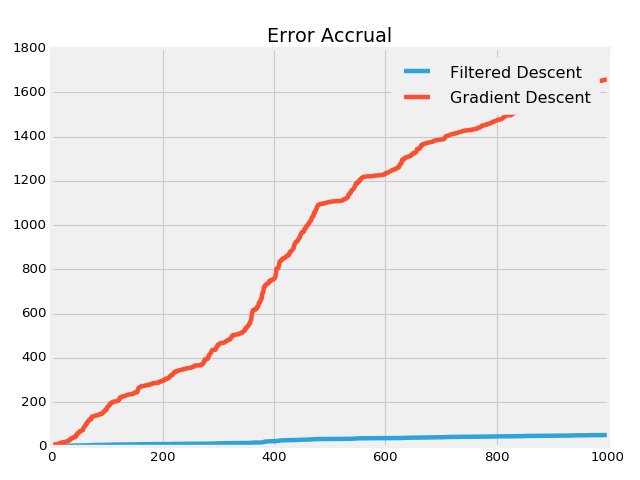

In [14]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

with plt.style.context('fivethirtyeight'):
    plt.plot([k for k in range(trials)], Error[:,0],label = "Filtered Descent")
    plt.plot([k for k in range(trials)], Error[:,1],label = "Gradient Descent")
    plt.legend()
    plt.title("Error Accrual")

plt.show()

In [438]:
sum(sum(g_filt.V-g_filt.V.T))

8.5265128291212022e-14

In [439]:
#Checking how symmetric our estimation is

E = g_filt.E

V = g_filt.V

H = dot(np.linalg.inv(E),V)

sum(sum(H-H.T))

1152.0